In [1]:
%matplotlib inline
# Andres  Coronado  2761046
# Giacomo Garbarino 4545532
import numpy as np
from scipy.interpolate import griddata
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import matplotlib.pyplot as plt

## Instructions on using Keras

Models in Keras are defined as a sequence of layers.

We create a [Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) object which holds multiple layers executed one by one, and add layers to the object until we have formed the architecture.

To create the first layer, you need to know the right number of input features. You can specify this by using the `input_dim` argument. 

The things to choose when defining the architecture are many:
 - number of layers
 - type of layers
 - size of layers
 - type of non-linearity
 - whether or not to add regularization
 
Here we will use only fully-connected (dense) layers, so the type of layer is fixed. Fully connected layers are defined using the [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) class, which takes as parameters the number of neurons (which is the **dimension of the output**).

The activation functions are used after each dense layer. You can choose the activation functions for hidden layers yourself, a common choice being the [ReLU](https://www.tensorflow.org/api_docs/python/tf/keras/activations/relu) activation. But for the last layer, the activation must reflect the range of the outputs.

Since we will work with binary classification problem, the output should be between 0 and 1, which is then easy to map to any given class. To ensure this we can use the [Sigmoid](https://www.tensorflow.org/api_docs/python/tf/keras/activations/sigmoid) activation.


After having created a model you need to **compile** it. During the compilation phase you must specify some parameters related to how the model will be optimized:
 - The `optimizer`. For the following exercise you should use [SGD](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD), initialized with some learning rate (instructions on how to choose it follow).
 - The `loss` function. For binary classification you can use the [cross-entropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy) loss.
 - A list of `metrics`: common error functions which you want keras to report at each training epoch.
 
Then you may actually train the model by calling **fit**. The fit function takes as input the training data, and some more parameters related to the training process:
 - `epochs` : the number of epochs to train for
 - `batch_size` : the size of mini-batches. A high batch-size will speed up computations but may make training unstable.
 
Other useful functions are `model.predict` which runs the model's forward pass to predict on new samples, and `model.evaluate` which is similar to `predict` but instead of giving predictions as output, it simply computes some metrics.

In [2]:
def generate_2d_cls_data(n, sigma_noise):
    n_cls = n // 2
    
    theta = np.random.randn(n_cls) * 2 * np.pi
    cls1 = np.stack([np.cos(theta) * 2, np.sin(theta) * 2], axis=1)
    cls2 = np.random.randn(n_cls, 2) * 0.5

    cls1 += np.random.randn(cls1.shape[0], 2) * sigma_noise * 3
    cls2 += np.random.randn(cls2.shape[0], 2) * sigma_noise
    
    X = np.concatenate([cls1, cls2], axis=0)
    y = np.concatenate([np.zeros(n_cls), np.ones(n_cls)], axis=0)
    
    return X, y

In [3]:
def separatingFLR(data, labels, predictions, model):
    fig, ax = plt.subplots()
    
    num_grid_points = 100
    xi = np.linspace(data[:, 0].min(), data[:, 0].max(), num_grid_points)
    yi = np.linspace(data[:, 1].min(), data[:, 1].max(), num_grid_points)
    gdata = np.stack([xi, yi], 1)
    X, Y = np.meshgrid(xi,yi)
    pred_grid = model.predict(
        np.stack([X.reshape(-1), Y.reshape(-1)], axis=1)
    ).reshape(num_grid_points, num_grid_points)
    
    ax.contour(xi, yi, pred_grid, 15, linewidths=2, colors='k', levels=[0.5])
    # plot data points.
    ax.scatter(data[:,0], data[:,1], c=labels.ravel(), marker='o', s=100, zorder=10, alpha=0.8)
    ax.set_xlim(data[:,0].min(), data[:,0].max())
    ax.set_ylim(data[:,1].min(), data[:,1].max())
    return fig, ax

In [4]:
def calc_err(predicted, observed):
    predicted = predicted.ravel()
    observed = observed.ravel()
    threshold_preds = predicted.copy()
    threshold_preds[predicted < 0.5] = 0
    threshold_preds[predicted >= 0.5] = 1
    return np.mean(threshold_preds != observed)

## Exploring Different Architectures

Using a simple binary classification dataset you will build a keras model with Dense layers, and the RELU activation function.

You will explore different architectures to try and see when the NN overfits or underfits the data.

In particular, you should try the following:
 1. A NN with a single hidden layer with few (e.g. 3, 4) neurons
 2. A NN with a single hidden layer with many (e.g. 100) neurons
 3. A NN with many (e.g. 3, 4, 5) hidden layers with a few neurons (e.g. 10 to 30).
 
Train the neural network using the SGD algorithm with a learning rate of 0.05 (you may explore different values) for 500 epochs (or less if time doesn't permit).

For each setting you try, plot the training and validation errors as a function of the epochs, and plot the separating function (use the `separatingFLR` function).

For each setting comment on whether the NN is overfitting or not. Further comment on which model you believe is better, and why (e.g. computational or accuracy considerations).

We provide some skeleton code to train and evaluate a model, you'll have to fill it in, and do the same thing multiple times for different models.

#### Generating the train and test sets

Note that with neural nets, the labels for binary classification should be 0 and +1.

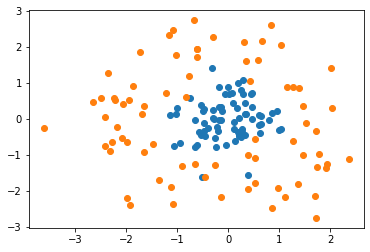

In [5]:
np.random.seed(34)
Xtr, Ytr = generate_2d_cls_data(150, 0.2)
Xte, Yte = generate_2d_cls_data(100, 0.2)

fig, ax = plt.subplots()
ax.scatter(Xtr[Ytr == 1,0], Xtr[Ytr == 1, 1])
ax.scatter(Xtr[Ytr == 0,0], Xtr[Ytr == 0, 1])

#### Build a model, train it and plot the results

In [6]:
# With this function you can plot the history of the model training produced by the fit function
def plot_history(history):
    fig, ax = plt.subplots()
    # Plot training & validation accuracy values
    ax.plot(history.history['accuracy'], label='Train')
    ax.plot(history.history['val_accuracy'], label='Val')
    ax.set_title('Model accuracy')
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Epoch')
    ax.legend(loc='best')
    return fig, ax

#### Case 1: hidden layers=1 and neurons=2

In [7]:
model = Sequential()
model.add(Dense(2, input_dim=Xtr.shape[1], activation='relu')) # First hidden layer plus input layer
model.add(Dense(1, activation='sigmoid'))  # This is the output layer, it should have 1 neuron and the sigmoid activation
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.05), # Algorithm used for optimization
    loss='binary_crossentropy',                         # The loss function
    metrics=['accuracy'],                               # Metrics to evaluate the goodness of predictions
)
history = model.fit(
    Xtr, Ytr,                       # Training data
    epochs=600,                     # Number of training epochs
    batch_size=10,                  # Train using mini-batches of 10 samples each
    validation_split=0.2,           # Split the data using 80% to train and 20% for validation
)
# Predict and calculate errors
train_preds = model.predict(Xtr)
test_preds = model.predict(Xte)
train_err = calc_err(train_preds, Ytr)
test_err = calc_err(test_preds, Yte)
print("Training error: %.2f%%, Test error: %.2f%%" % (train_err * 100, test_err * 100))

Epoch 1/600
12/12 [==============================] - 1s 29ms/step - loss: 0.7477 - accuracy: 0.4250 - val_loss: 0.7270 - val_accuracy: 0.1667
Epoch 2/600
12/12 [==============================] - 0s 5ms/step - loss: 0.6946 - accuracy: 0.4333 - val_loss: 0.7799 - val_accuracy: 0.0000e+00
Epoch 3/600
12/12 [==============================] - 0s 6ms/step - loss: 0.6620 - accuracy: 0.6167 - val_loss: 0.8210 - val_accuracy: 0.0000e+00
Epoch 4/600
12/12 [==============================] - 0s 5ms/step - loss: 0.6405 - accuracy: 0.6250 - val_loss: 0.8535 - val_accuracy: 0.0000e+00
Epoch 5/600
12/12 [==============================] - 0s 5ms/step - loss: 0.6238 - accuracy: 0.6250 - val_loss: 0.8786 - val_accuracy: 0.0000e+00
Epoch 6/600
12/12 [==============================] - 0s 7ms/step - loss: 0.6112 - accuracy: 0.6250 - val_loss: 0.9000 - val_accuracy: 0.0000e+00
Epoch 7/600
12/12 [==============================] - 0s 5ms/step - loss: 0.6006 - accuracy: 0.6250 - val_loss: 0.9147 - val_accuracy:

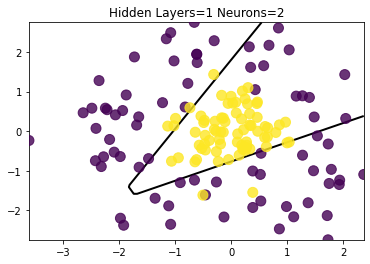

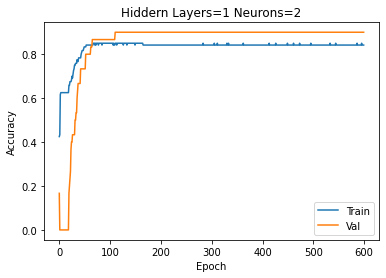

In [8]:
fig, ax = separatingFLR(Xtr, Ytr, train_preds, model)
ax.set_title("Hidden Layers=1 Neurons=2");
fig, ax = plot_history(history)
ax.set_title("Hiddern Layers=1 Neurons=2");

#### Case 2: hidden layers=1 and neurons=4

In [9]:
model = Sequential()
model.add(Dense(4, input_dim=Xtr.shape[1], activation='relu')) # First hidden Layer plus input layer
model.add(Dense(1, activation='sigmoid'))  # This is the output layer, it should have 1 neuron and the sigmoid activation
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.05), # Algorithm used for optimization
    loss='binary_crossentropy',                         # The loss function
    metrics=['accuracy'],                               # Metrics to evaluate the goodness of predictions
)
history = model.fit(
    Xtr, Ytr,                       # Training data
    epochs=600,                     # Number of training epochs
    batch_size=10,                  # Train using mini-batches of 10 samples each
    validation_split=0.2,           # Split the data using 80% to train and 20% for validation
)
# Predict and calculate errors
train_preds = model.predict(Xtr)
test_preds = model.predict(Xte)
train_err = calc_err(train_preds, Ytr)
test_err = calc_err(test_preds, Yte)
print("Training error: %.2f%%, Test error: %.2f%%" % (train_err * 100, test_err * 100))

Epoch 1/600
12/12 [==============================] - 1s 35ms/step - loss: 0.6435 - accuracy: 0.5833 - val_loss: 0.8475 - val_accuracy: 0.1667
Epoch 2/600
12/12 [==============================] - 0s 6ms/step - loss: 0.6108 - accuracy: 0.5750 - val_loss: 0.8879 - val_accuracy: 0.0667
Epoch 3/600
12/12 [==============================] - 0s 6ms/step - loss: 0.5935 - accuracy: 0.6083 - val_loss: 0.9138 - val_accuracy: 0.0333
Epoch 4/600
12/12 [==============================] - 0s 6ms/step - loss: 0.5820 - accuracy: 0.6167 - val_loss: 0.9217 - val_accuracy: 0.0000e+00
Epoch 5/600
12/12 [==============================] - 0s 4ms/step - loss: 0.5744 - accuracy: 0.6250 - val_loss: 0.9220 - val_accuracy: 0.0000e+00
Epoch 6/600
12/12 [==============================] - 0s 4ms/step - loss: 0.5662 - accuracy: 0.6250 - val_loss: 0.9267 - val_accuracy: 0.0000e+00
Epoch 7/600
12/12 [==============================] - 0s 5ms/step - loss: 0.5608 - accuracy: 0.6167 - val_loss: 0.9275 - val_accuracy: 0.0667


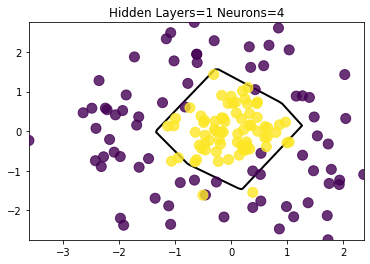

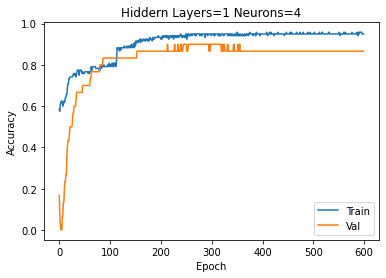

In [10]:
fig, ax = separatingFLR(Xtr, Ytr, train_preds, model)
ax.set_title("Hidden Layers=1 Neurons=4");
fig, ax = plot_history(history)
ax.set_title("Hiddern Layers=1 Neurons=4");

#### Case 3: hidden layers=1 and neurons=100

In [11]:
model = Sequential()
model.add(Dense(100, input_dim=Xtr.shape[1], activation='relu')) # First hidden Layer plus input layer
model.add(Dense(1, activation='sigmoid'))  # This is the output layer, it should have 1 neuron and the sigmoid activation
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.05), # Algorithm used for optimization
    loss='binary_crossentropy',                         # The loss function
    metrics=['accuracy'],                               # Metrics to evaluate the goodness of predictions
)
history = model.fit(
    Xtr, Ytr,                       # Training data
    epochs=600,                     # Number of training epochs
    batch_size=10,                  # Train using mini-batches of 10 samples each
    validation_split=0.2,           # Split the data using 80% to train and 20% for validation
)
# Predict and calculate errors
train_preds = model.predict(Xtr)
test_preds = model.predict(Xte)
train_err = calc_err(train_preds, Ytr)
test_err = calc_err(test_preds, Yte)
print("Training error: %.2f%%, Test error: %.2f%%" % (train_err * 100, test_err * 100))

Epoch 1/600
12/12 [==============================] - 1s 25ms/step - loss: 0.6219 - accuracy: 0.6250 - val_loss: 0.8020 - val_accuracy: 0.0000e+00
Epoch 2/600
12/12 [==============================] - 0s 5ms/step - loss: 0.5795 - accuracy: 0.6250 - val_loss: 0.8416 - val_accuracy: 0.0000e+00
Epoch 3/600
12/12 [==============================] - 0s 6ms/step - loss: 0.5509 - accuracy: 0.6250 - val_loss: 0.8638 - val_accuracy: 0.0000e+00
Epoch 4/600
12/12 [==============================] - 0s 6ms/step - loss: 0.5328 - accuracy: 0.6250 - val_loss: 0.8722 - val_accuracy: 0.0000e+00
Epoch 5/600
12/12 [==============================] - 0s 6ms/step - loss: 0.5160 - accuracy: 0.6250 - val_loss: 0.8645 - val_accuracy: 0.0000e+00
Epoch 6/600
12/12 [==============================] - 0s 7ms/step - loss: 0.5022 - accuracy: 0.6417 - val_loss: 0.8598 - val_accuracy: 0.0333
Epoch 7/600
12/12 [==============================] - 0s 6ms/step - loss: 0.4902 - accuracy: 0.6583 - val_loss: 0.8529 - val_accuracy:

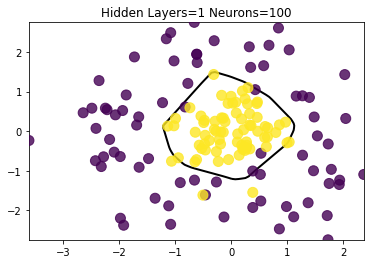

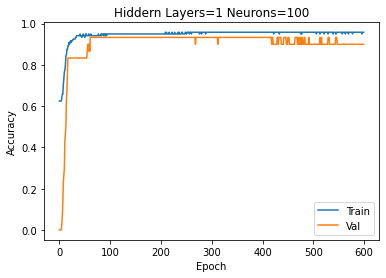

In [12]:
fig, ax = separatingFLR(Xtr, Ytr, train_preds, model)
ax.set_title("Hidden Layers=1 Neurons=100");
fig, ax = plot_history(history)
ax.set_title("Hiddern Layers=1 Neurons=100");

#### Case 4: hidden layers=4 and neurons=[10;30] per layer

In [13]:
model = Sequential()
model.add(Dense(30, input_dim=Xtr.shape[1], activation='relu')) # First hidden Layer plus input layer
model.add(Dense(15, activation='relu')) # Second hidden layer
model.add(Dense(20, activation='relu')) # Third hidden layer
model.add(Dense(10, activation='relu')) # Forth hidden layer
model.add(Dense(1, activation='sigmoid'))  # This is the output layer, it should have 1 neuron and the sigmoid activation
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.05), # Algorithm used for optimization
    loss='binary_crossentropy',                         # The loss function
    metrics=['accuracy'],                               # Metrics to evaluate the goodness of predictions
)
history = model.fit(
    Xtr, Ytr,                       # Training data
    epochs=600,                     # Number of training epochs
    batch_size=10,                  # Train using mini-batches of 10 samples each
    validation_split=0.2,           # Split the data using 80% to train and 20% for validation
)
# Predict and calculate errors
train_preds = model.predict(Xtr)
test_preds = model.predict(Xte)
train_err = calc_err(train_preds, Ytr)
test_err = calc_err(test_preds, Yte)
print("Training error: %.2f%%, Test error: %.2f%%" % (train_err * 100, test_err * 100))

Epoch 1/600
12/12 [==============================] - 1s 28ms/step - loss: 0.7062 - accuracy: 0.4917 - val_loss: 0.7572 - val_accuracy: 0.0000e+00
Epoch 2/600
12/12 [==============================] - 0s 6ms/step - loss: 0.6610 - accuracy: 0.6250 - val_loss: 0.8144 - val_accuracy: 0.0000e+00
Epoch 3/600
12/12 [==============================] - 0s 6ms/step - loss: 0.6353 - accuracy: 0.6250 - val_loss: 0.8609 - val_accuracy: 0.0000e+00
Epoch 4/600
12/12 [==============================] - 0s 5ms/step - loss: 0.6119 - accuracy: 0.6250 - val_loss: 0.8926 - val_accuracy: 0.0000e+00
Epoch 5/600
12/12 [==============================] - 0s 5ms/step - loss: 0.5902 - accuracy: 0.6250 - val_loss: 0.9154 - val_accuracy: 0.0000e+00
Epoch 6/600
12/12 [==============================] - 0s 5ms/step - loss: 0.5641 - accuracy: 0.6250 - val_loss: 0.9253 - val_accuracy: 0.0000e+00
Epoch 7/600
12/12 [==============================] - 0s 5ms/step - loss: 0.5394 - accuracy: 0.6250 - val_loss: 0.8997 - val_accur

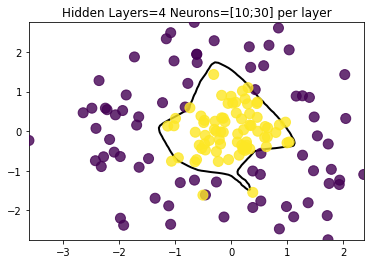

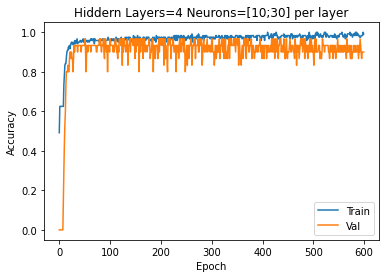

In [14]:
fig, ax = separatingFLR(Xtr, Ytr, train_preds, model)
ax.set_title("Hidden Layers=4 Neurons=[10;30] per layer");
fig, ax = plot_history(history)
ax.set_title("Hiddern Layers=4 Neurons=[10;30] per layer");

## Train a Neural Network on MNIST!

We can finally switch to a real dataset now.

First we will load the MNIST dataset and plot it to see how it really looks like.

Then we will use the notions learned in the first part to train a model which can distinguish two digits in the MNIST data.

As a bonus, some of you may want to look into multi-class classification and train a model on the whole MNIST dataset!

## Load Data

In [15]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
print("Training set shapes: ", x_train.shape, y_train.shape)
print("Test set shapes: ", x_test.shape, y_test.shape)

Training set shapes:  (60000, 28, 28) (60000,)
Test set shapes:  (10000, 28, 28) (10000,)


Take a look at the data, try plotting the images.

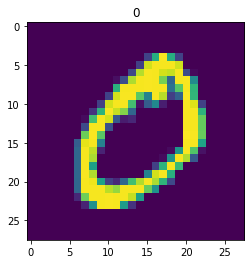

In [16]:
fig, ax = plt.subplots()
ax.imshow(x_train[1])
ax.set_title(y_train[1]);

In [17]:
# Have a look at the targets. This is a multiclass problem!
print(y_train[0], y_train[1])

5 0


#### Bring the data into shape

1. Choose the digits we want to classify (variables `num_1` and `num_2`)
2. Then we restrict training and test sets to only use those numbers
3. We reshape the images from 28*28 to a single 784-dimensional vector
4. Finally we modify the labels to their appropriate range (0 and +1)

In [18]:
num_1 = 1
num_2 = 7

# Here we take only two digits from MNIST. 
# We will reduce the problem to binary classification.
Xtr = x_train[(y_train == num_1) | (y_train == num_2)]
Ytr = y_train[(y_train == num_1) | (y_train == num_2)]
Xts = x_test[(y_test == num_1) | (y_test == num_2)]
Yts = y_test[(y_test == num_1) | (y_test == num_2)]

# Reshape the data correctly
Xtr = Xtr.reshape(-1, 28*28)
Xts = Xts.reshape(-1, 28*28)
Ytr[Ytr == num_1] = 0
Ytr[Ytr == num_2] = 1
Yts[Yts == num_1] = 0
Yts[Yts == num_2] = 1

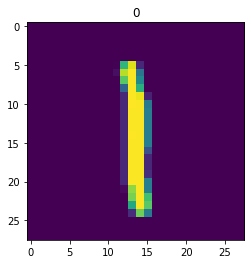

In [19]:
fig, ax = plt.subplots()
ax.imshow(Xtr[3].reshape(28, 28))
ax.set_title(Ytr[3]);

#### Define The Keras Model

In [20]:
model = Sequential()
model.add(Dense(4, input_dim=Xtr.shape[1], activation='relu'))
model.add(Dense(1, activation='sigmoid'))

#### Compile The Keras Model

Here we will use the Adam optimizer instead. It tends to work better than SGD with high dimensional data (such as our MNIST images).

In [21]:
model.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy'],)

#### Fit the model

In [22]:
# fit the keras model on the dataset
history = model.fit(Xtr, Ytr, 
                    epochs=50, 
                    batch_size=10,
                    validation_split=0.2)

Epoch 1/50
1041/1041 [==============================] - 3s 3ms/step - loss: 0.3876 - accuracy: 0.9343 - val_loss: 0.2121 - val_accuracy: 0.9923
Epoch 2/50
1041/1041 [==============================] - 2s 2ms/step - loss: 0.1653 - accuracy: 0.9865 - val_loss: 0.1250 - val_accuracy: 0.9935
Epoch 3/50
1041/1041 [==============================] - 2s 2ms/step - loss: 0.1118 - accuracy: 0.9891 - val_loss: 0.0770 - val_accuracy: 0.9958
Epoch 4/50
1041/1041 [==============================] - 2s 2ms/step - loss: 0.0645 - accuracy: 0.9936 - val_loss: 0.0518 - val_accuracy: 0.9954
Epoch 5/50
1041/1041 [==============================] - 3s 3ms/step - loss: 0.0414 - accuracy: 0.9963 - val_loss: 0.0346 - val_accuracy: 0.9977
Epoch 6/50
1041/1041 [==============================] - 3s 2ms/step - loss: 0.0282 - accuracy: 0.9961 - val_loss: 0.0324 - val_accuracy: 0.9965
Epoch 7/50
1041/1041 [==============================] - 3s 2ms/step - loss: 0.0236 - accuracy: 0.9965 - val_loss: 0.0177 - val_accuracy:

In [23]:
# Predict and calculate errors
train_preds = model.predict(Xtr)
test_preds = model.predict(Xts)
train_err = calc_err(train_preds, Ytr)
test_err = calc_err(test_preds, Yts)
print("Hidden Layers=1  Neurons=4")
print("Training error: %.2f%%, Test error: %.2f%%" % (train_err * 100, test_err * 100))

Hidden Layers=1  Neurons=4
Training error: 0.06%, Test error: 0.51%


In [24]:
# evaluate the keras model. Is this consistent with the error you computed above?
_, accuracy = model.evaluate(Xts, Yts)
print('Test accuracy: %.2f%%' % (accuracy*100))

68/68 [==============================] - 0s 2ms/step - loss: 0.0624 - accuracy: 0.9949
Test accuracy: 99.49%


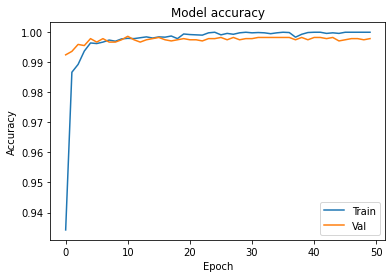

In [25]:
# Plot training history
fig, ax = plot_history(history)